# 📦 Scenario 01 — Inventory Accuracy & Utilization

This workbook renders supporting visuals for the executive summary:
- Utilization & capital allocation (working‑capital lens)
- Category attention mix (risk distribution)
- Returns quality (non‑restockable loss)
- Optional risk quadrant (utilization × non‑restockable)

> **Goal:** quantify where capital is locked, show how evenly risk is spread, and surface the quality drag on recovery value.

## ⚙️ Setup & Data Check

We connect to `ecom_retailer.db` and verify the presence of the audit object (`inventory_audit`).  
If the view/table is missing, run the build SQL first, then re‑run this notebook.

In [1]:
# --- Load-in and database connection ---

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path

# --- Configuration ---
# The database file should be in the same directory as this notebook.
# NOTE: For this relative path to work, please ensure you launch the Jupyter server
# from this notebook's directory ('story_01_inventory_accuracy').
DB_PATH = "ecom_retailer.db"

# --- Connection and Verification ---
# Establish the connection to the SQLite database.
# sqlite3.connect() will create an empty file if the DB doesn't exist at the specified path.
conn = sqlite3.connect(DB_PATH)

# **Verification Step**
# Let's check if we connected to the correct database by looking for our main view.
# This helps catch pathing errors early.
try:
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='view' AND name='inventory_audit';")
    result = cursor.fetchone()
    if result:
        print(f"✅ Successfully connected to '{os.path.abspath(DB_PATH)}'")
        print(f"   View 'inventory_audit' found.")
    else:
        print(f"⚠️ Connection made, but 'inventory_audit' view not found in '{os.path.abspath(DB_PATH)}'.")
        print("   Please ensure the path is correct and you have run the `build_inventory_audit_view.sql` script.")
except sqlite3.Error as e:
    print(f"❌ Database connection failed: {e}")

✅ Successfully connected to '/Users/garrettschumacher/Documents/git_repos/dev_sql_stories/ecom_retailer.db'
   View 'inventory_audit' found.


### 🔍 Inventory Audit — Validation Notes  

- **Schema:** The audit view provides ratios only (no raw `stock_on_hand` or `units_sold` counts).  
- **Utilization:** One SKU (`modern lamp`) exceeds 1.0 utilization (≈1.14). This likely represents a stockout/backorder case, which is a valid anomaly for audit review.  
- **Outliers:**  
  - 17 SKUs flagged as utilization outliers (very high/low efficiency).  
  - 6 SKUs flagged as return-rate outliers (excessive returns).  
  These are retained as **signals**, not dropped, since the audit’s purpose is to surface exceptions.  

✅ Overall, the dataset is clean enough for visualization and analysis, with flagged anomalies treated as business-relevant insights rather than data errors.

In [2]:
# Lightweight validation for `inventory_audit`

# --- Reuse existing helpers if available, otherwise make a tiny fallback ---
def _detect_root():
    for r in [Path("."), Path(".."), Path("../..")]:
        if (r / "ecom_retailer.db").exists():
            return r.resolve()
    return Path(".").resolve()

try:
    q  # if q() already defined, we'll use it
    _HAS_Q = True
except NameError:
    _HAS_Q = False
    ROOT = _detect_root()
    DB_PATH = ROOT / "ecom_retailer.db"
    conn = sqlite3.connect(str(DB_PATH))
    def q(sql, params=None):
        return pd.read_sql_query(sql, conn, params=params)

checks = []
def ok(name, cond, detail=""):
    checks.append((name, bool(cond), detail))

# --- 1) view exists ---
v = q("SELECT name FROM sqlite_master WHERE type IN ('view','table') AND name='inventory_audit';")
ok("inventory_audit is present", not v.empty)

if v.empty:
    # Print summary and bail early
    print("⚠️ `inventory_audit` not found. Run the build SQL (e.g., `build_inventory_audit_view.sql`) and re-run this notebook.")
else:
    # --- 2) load & schema checks ---
    df = q("SELECT * FROM inventory_audit;")
    ok("inventory_audit not empty", not df.empty, f"rows={len(df)}")

    expected = {
        "product_id", "product_name",
        "stock_on_hand", "units_sold",
        "inventory_utilization_ratio",  # sold / stocked (or equivalent)
        "nonrestock_rate",              # fraction not restocked
        "return_rate"                   # fraction returned
    }
    missing = expected - set(df.columns)
    ok("expected columns present", len(missing) == 0, f"missing={sorted(missing)}")

    # --- 3) range checks on key rates in [0,1] ---
    def in_01(s):
        x = pd.to_numeric(s, errors="coerce")
        return x.dropna().between(0, 1).all(), (x.min(skipna=True), x.max(skipna=True))

    for col in ["inventory_utilization_ratio", "nonrestock_rate", "return_rate"]:
        if col in df.columns:
            passed, (mn, mx) = in_01(df[col])
            ok(f"{col} in [0,1]", passed, f"min={mn}, max={mx}")

    # --- 4) anomalies: utilization > 1.0 (and >1.1 severe) ---
    if "inventory_utilization_ratio" in df.columns:
        util = pd.to_numeric(df["inventory_utilization_ratio"], errors="coerce")
        over_1 = df[util > 1.0]
        over_11 = df[util > 1.1]
        ok("utilization ≤ 1.0 (no theoretical over-sell)", over_1.empty, f"n_over_1={len(over_1)}; n_over_1.1={len(over_11)}")

        # quick peek at top offenders (won't spam: show up to 5)
        if not over_1.empty:
            cols_show = [c for c in ["product_id","product_name","stock_on_hand","units_sold","inventory_utilization_ratio","return_rate"] if c in df.columns]
            display(over_1.sort_values("inventory_utilization_ratio", ascending=False)[cols_show].head(5))

# --- Outlier check for inventory_audit key metrics ---

df = q("SELECT product_id, product_name, inventory_utilization_ratio, nonrestock_rate, return_rate FROM inventory_audit;")

def outlier_summary(series, name, z_thresh=3):
    """Flag extreme values by z-score."""
    s = pd.to_numeric(series, errors="coerce").dropna()
    if s.empty:
        return f"{name}: no data"
    z = (s - s.mean()) / s.std(ddof=0)
    outliers = s[abs(z) > z_thresh]
    if not outliers.empty:
        return f"{name}: ⚠️ {len(outliers)} outliers (>{z_thresh}σ) — min={s.min():.3f}, max={s.max():.3f}"
    else:
        return f"{name}: ✅ no extreme outliers — min={s.min():.3f}, max={s.max():.3f}"

print(outlier_summary(df["inventory_utilization_ratio"], "inventory_utilization_ratio"))
print(outlier_summary(df["nonrestock_rate"], "nonrestock_rate"))
print(outlier_summary(df["return_rate"], "return_rate"))

# Optional: peek at top offenders for utilization >1.0
over_1 = df[df["inventory_utilization_ratio"] > 1.0]
if not over_1.empty:
    print("\n🚩 SKUs with utilization > 1.0 (possible stockouts/data anomalies):")
    display(over_1[["product_id","product_name","inventory_utilization_ratio"]].head(5))
    
    # --- 5) print summary ---
    print("Inventory Audit — Validation Summary")
    for name, passed, detail in checks:
        badge = "✅" if passed else "⚠️"
        print(f"{badge} {name}" + (f" — {detail}" if detail else ""))

,product_id,product_name,inventory_utilization_ratio,return_rate
348,349,modern lamp,1.138614,0.087302


inventory_utilization_ratio: ⚠️ 17 outliers (>3σ) — min=0.077, max=1.139
nonrestock_rate: ✅ no extreme outliers — min=0.000, max=1.000
return_rate: ⚠️ 6 outliers (>3σ) — min=0.000, max=0.457

🚩 SKUs with utilization > 1.0 (possible stockouts/data anomalies):


,product_id,product_name,inventory_utilization_ratio
348,349,modern lamp,1.138614


Inventory Audit — Validation Summary
✅ inventory_audit is present
✅ inventory_audit not empty — rows=1286
⚠️ expected columns present — missing=['stock_on_hand', 'units_sold']
⚠️ inventory_utilization_ratio in [0,1] — min=0.07692307692307693, max=1.1386138613861385
✅ nonrestock_rate in [0,1] — min=0.0, max=1.0
✅ return_rate in [0,1] — min=0.0, max=0.45652173913043476
⚠️ utilization ≤ 1.0 (no theoretical over-sell) — n_over_1=1; n_over_1.1=1


In [3]:
# --- Inspect columns ---
cursor = conn.cursor()
cursor.execute("PRAGMA table_info(inventory_audit);")
for col in cursor.fetchall():
    print(col)

(0, 'product_id', 'INTEGER', 0, None, 0)
(1, 'product_name', '', 0, None, 0)
(2, 'category', '', 0, None, 0)
(3, 'inventory_quantity', 'INTEGER', 0, None, 0)
(4, 'total_sold', '', 0, None, 0)
(5, 'total_returned', '', 0, None, 0)
(6, 'net_units_sold', '', 0, None, 0)
(7, 'inventory_utilization_ratio', '', 0, None, 0)
(8, 'gross_sales_amount', '', 0, None, 0)
(9, 'gross_refunded_amount', '', 0, None, 0)
(10, 'restockable_qty', '', 0, None, 0)
(11, 'nonrestockable_qty', '', 0, None, 0)
(12, 'nonrestock_rate', '', 0, None, 0)
(13, 'oversold_flag', '', 0, None, 0)
(14, 'inv_attention_flag', '', 0, None, 0)
(15, 'return_rate', '', 0, None, 0)
(16, 'inv_attention_score', '', 0, None, 0)
(17, 'inv_attention_tier', '', 0, None, 0)


## 📊 KPI Snapshot (Catalog‑Wide)

**What we calculate**
- **Avg Utilization (%)** — unweighted view of sell‑through by SKU.  
- **Weighted Utilization (%)** — units‑weighted view across the catalog.  
- **Tied‑Up Capital ($)** — value of excess units (working capital locked).  
- **Scenarios (10/20/30%)** — potential cash unlocked with reductions.

**Why it matters**  
This frames the scale of inefficiency and the immediate cash opportunity from reducing slow‑moving stock.

In [4]:
# --- Surface Utilization KPI's ---

sql_kpis = """
WITH inv AS (
    SELECT
        category,
        SUM(inventory_quantity) AS total_inv,
        SUM(total_sold)         AS total_sold,
        SUM(total_returned)     AS total_returned,

        -- Capital tied up in excess units, approximated at avg unit price
        -- avg_unit_price ≈ gross_sales_amount / total_sold
        SUM(
          CASE
            WHEN (inventory_quantity - net_units_sold) > 0 AND total_sold > 0 THEN
              (inventory_quantity - net_units_sold) * (gross_sales_amount * 1.0 / total_sold)
            ELSE 0
          END
        ) AS tied_up
    FROM inventory_audit
    GROUP BY category
)
SELECT
    SUM(total_inv)  AS total_inventory_units,
    SUM(total_sold) AS total_sold_units,
    SUM(total_returned) AS total_returned_units,
    ROUND(SUM(tied_up), 2) AS total_tied_up_usd,

    -- Simple average of SKU-level utilization across categories (unweighted)
    ROUND(AVG((total_sold - total_returned) * 1.0 / NULLIF(total_inv,0)) * 100, 1) AS avg_utilization_pct,

    -- Weighted utilization across the whole catalog (units-based)
    ROUND(
      (SUM(total_sold - total_returned) * 1.0) / NULLIF(SUM(total_inv),0) * 100, 1
    ) AS weighted_utilization_pct
FROM inv;
"""
df_kpis = pd.read_sql(sql_kpis, conn)
df_kpis

,total_inventory_units,total_sold_units,total_returned_units,total_tied_up_usd,avg_utilization_pct,weighted_utilization_pct
0,224925,86607,13323,19053395.37,32.8,32.6


## 🧭 Category Attention Mix (Table)

This table shows the **share of SKUs by attention tier** within each category.  
Key pattern: **“Moderate Attention” dominates (~40–50%)** across most categories, while **“High Attention”** remains a **small minority** (1–5%) — indicating **systemic under‑performance** rather than one category driving risk.

**How to read**
- **pct_within_category** = % of SKUs in that tier for the category (sums to ~100%).  
- Use this to confirm that **risk is broadly distributed**, not isolated.


In [5]:
# --- View Attention Flag Tiers ---

sql_tiers = """
SELECT
    category,
    inv_attention_tier,
    COUNT(DISTINCT product_id) AS n_products,
    ROUND(
      100.0 * COUNT(DISTINCT product_id)
      / SUM(COUNT(DISTINCT product_id)) OVER (PARTITION BY category), 1
    ) AS pct_within_category
FROM inventory_audit
GROUP BY category, inv_attention_tier
ORDER BY category, inv_attention_tier;
"""
df_tiers = pd.read_sql(sql_tiers, conn)
df_tiers

,category,inv_attention_tier,n_products,pct_within_category
0,books,Tier 0 – Healthy,140,52.4
1,books,Tier 1 – Low Attention,9,3.4
2,books,Tier 2 – Moderate Attention,110,41.2
3,books,Tier 3 – High Attention,8,3.0
4,clothing,Tier 0 – Healthy,106,43.6
5,clothing,Tier 1 – Low Attention,12,4.9
6,clothing,Tier 2 – Moderate Attention,117,48.1
7,clothing,Tier 3 – High Attention,8,3.3
8,electronics,Tier 0 – Healthy,144,54.5
9,electronics,Tier 1 – Low Attention,9,3.4


## 📉 SKU‑Level Utilization (Histogram)

The utilization distribution is **skewed low** with a cluster below the **30%** threshold.  
Average utilization sits near **~32%**, confirming **under‑utilization** across a large share of SKUs.

**Why it matters**
- Low utilization = **slow‑moving inventory** → **working capital locked** and **higher carrying costs**.
- Inventory velocity is the lever; the histogram shows **breadth** of the issue (not just a few outliers).

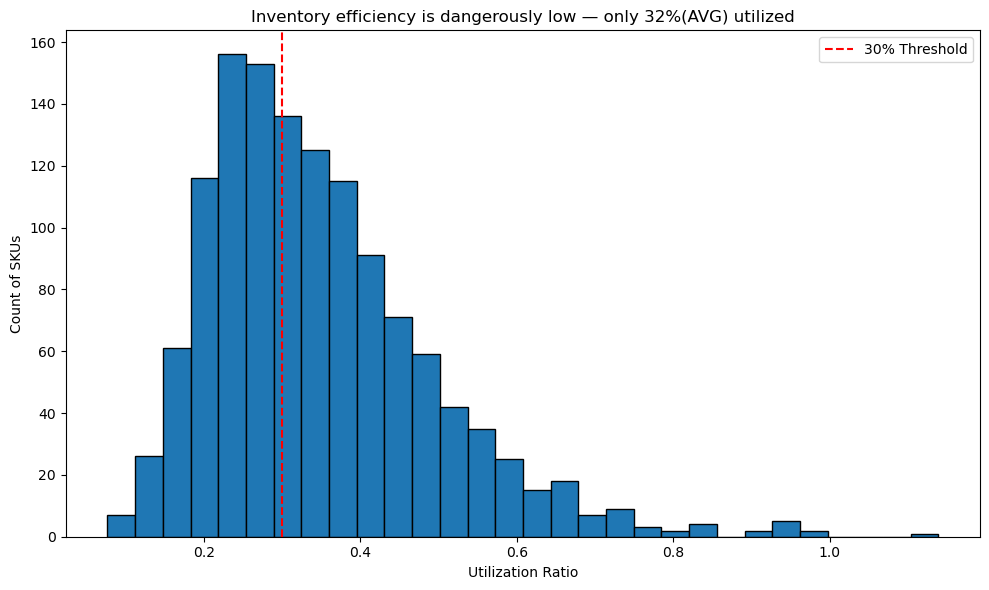

In [6]:
# --- plot SKU level Utilization ---

sql_util = """
SELECT
    product_id,
    category,
    (total_sold - total_returned) * 1.0 / NULLIF(inventory_quantity,0) AS utilization
FROM inventory_audit;
"""
df_util = pd.read_sql(sql_util, conn)

plt.figure(figsize=(10,6))
plt.hist(df_util["utilization"].dropna(), bins=30, edgecolor="black")
plt.axvline(0.30, color="red", linestyle="--", label="30% Threshold")
plt.title("Inventory efficiency is dangerously low — only 32%(AVG) utilized")
plt.xlabel("Utilization Ratio")
plt.ylabel("Count of SKUs")
plt.legend()
plt.tight_layout()
plt.show()

## 💰 Capital Locked in Excess Stock (Scenarios)

This table quantifies **excess stock value** by category and the **cash unlocked** under 10% / 20% / 30% reduction scenarios.

**Takeaways**
- Largest cash unlock opportunities: **clothing**, **toys**, **electronics**.  
- A **20% reduction** program alone frees **$0.76–$0.81M per top category**.

> Tip: Multiply the excess value by your **carrying cost rate (20–30%/yr)** to show **annual run‑rate savings** from inventory reduction.

In [7]:
# --- calculate excess stock value(USD$) ---

sql_capital = """
WITH cat_excess AS (
  SELECT 
    category,
    SUM(
      CASE
        WHEN (inventory_quantity - net_units_sold) > 0 AND total_sold > 0 THEN
          (inventory_quantity - net_units_sold) * (gross_sales_amount * 1.0 / total_sold)
        ELSE 0
      END
    ) AS excess_stock_value
  FROM inventory_audit
  GROUP BY category
)
SELECT 
  category,
  ROUND(excess_stock_value, 2)                AS excess_stock_value,
  ROUND(excess_stock_value * 0.10, 2)         AS savings_10pct,
  ROUND(excess_stock_value * 0.20, 2)         AS savings_20pct,
  ROUND(excess_stock_value * 0.30, 2)         AS savings_30pct
FROM cat_excess
ORDER BY excess_stock_value DESC;
"""
df_capital = pd.read_sql(sql_capital, conn)
df_capital

,category,excess_stock_value,savings_10pct,savings_20pct,savings_30pct
0,toys,4327161.48,432716.15,865432.30,1298148.44
1,books,4181343.77,418134.38,836268.75,1254403.13
2,electronics,3777528.14,377752.81,755505.63,1133258.44
3,clothing,3745567.43,374556.74,749113.49,1123670.23
4,home,3021794.55,302179.46,604358.91,906538.36


## 🟦 Risk Distribution by Category (100% Stacked)

Each bar normalizes a category to **100%** and shows the **tier mix** (Healthy → High Attention).  
Across categories, **Moderate Attention** is the largest slice (~40–50%), and **High Attention** remains small — reinforcing that **risk is even, not concentrated**.

**Action**
- Add **category‑level OKRs** tied to:  
  1) ↑ **utilization %**,  
  2) ↓ **excess value**, and  
  3) ↓ **share of Moderate/High** tiers.

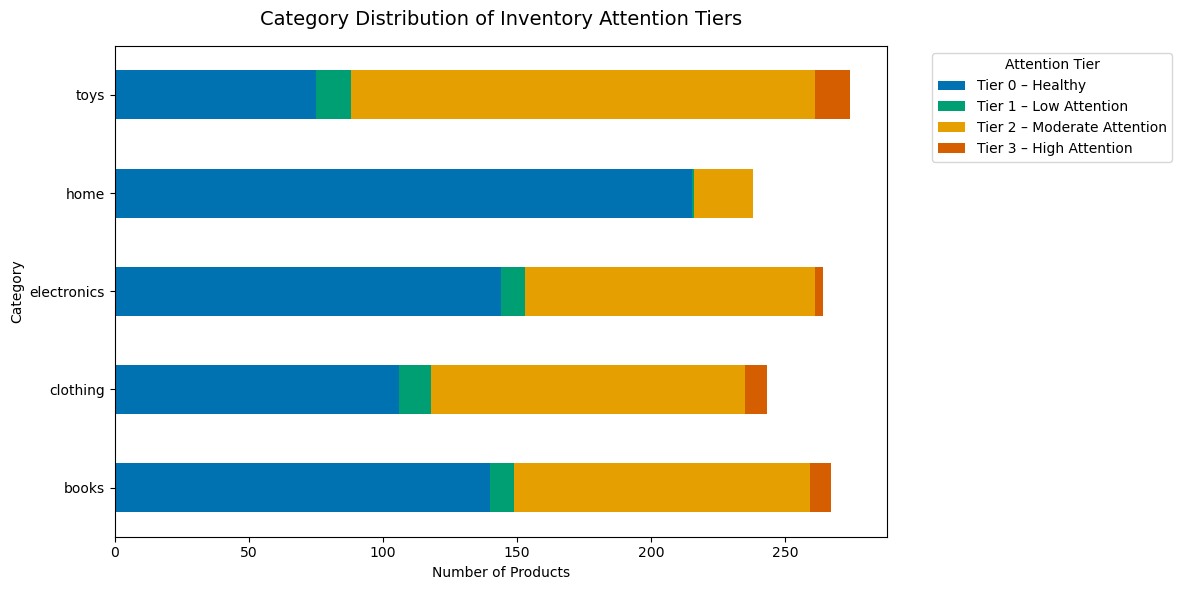

In [8]:
# ---- Plot Inv. Attention Flags by Category ---

sql_cat = """
SELECT 
    category,
    inv_attention_tier,
    COUNT(*) AS n_products
FROM inventory_audit
GROUP BY category, inv_attention_tier;
"""
df_cat = pd.read_sql(sql_cat, conn)

# Pivot for stacked bar
pivot = df_cat.pivot(index="category", columns="inv_attention_tier", values="n_products").fillna(0)

# --- Plot ---
colors = ["#0072B2", "#009E73", "#E69F00", "#D55E00"]

pivot.plot(
    kind="barh",
    stacked=True,
    figsize=(12, 6),
    color=colors
)

plt.title("Category Distribution of Inventory Attention Tiers", fontsize=14, pad=15)
plt.xlabel("Number of Products")
plt.ylabel("Category")
plt.legend(title="Attention Tier", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## 💰 Working Capital Allocation (Donut, $)

**Locked capital** = excess units × unit price.  
The donut splits **🔴 Locked Capital** vs **🟢 Productive Capital** and tags the **Total Inventory Value** in the center.

- **$19.2M locked** → that’s the cash sitting idle.  
- **Free 20%** → ~$3.8M unlocked, **plus** $0.8–$1.1M/yr carrying cost avoided (20–30% carrying rates).

Tied-Up Capital (derived): $19,053,395.37 | Total Inventory Value: $28,228,923.68


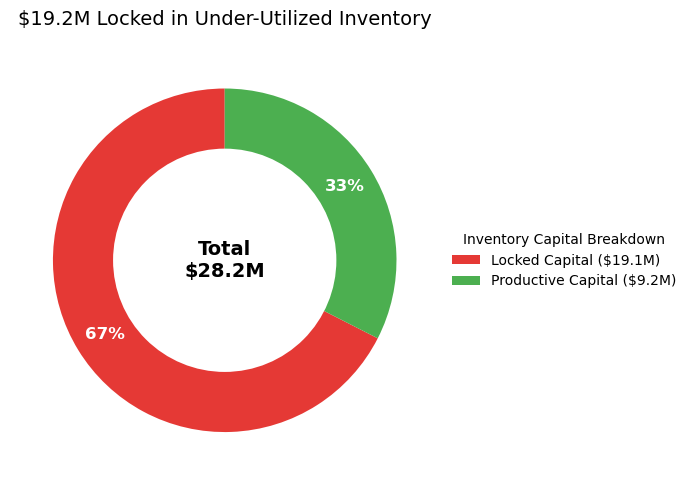

In [9]:
# --- Build DF and Plot Working Capital ---

# Compute tied-up capital (VALUE) using unit_price
sql_value = """
WITH base AS (
  SELECT
    ia.product_id,
    ia.category,
    ia.inv_attention_tier,
    MAX(ia.inventory_quantity - (ia.total_sold - ia.total_returned), 0) AS excess_units,
    ia.inventory_quantity,
    pc.unit_price
  FROM inventory_audit ia
  LEFT JOIN product_catalog pc
    ON pc.product_id = ia.product_id
  GROUP BY ia.product_id, ia.category, ia.inv_attention_tier
),
totals AS (
  SELECT
    SUM(excess_units * COALESCE(unit_price,0))        AS tied_up_value_usd,
    SUM(inventory_quantity * COALESCE(unit_price,0))  AS total_inventory_value_usd
  FROM base
)
SELECT tied_up_value_usd, total_inventory_value_usd FROM totals;
"""
df_val = pd.read_sql(sql_value, conn)
tied_up = float(df_val.loc[0, "tied_up_value_usd"] or 0.0)
total_val = float(df_val.loc[0, "total_inventory_value_usd"] or 0.0)
productive_val = max(total_val - tied_up, 0.0)

print(f"Tied-Up Capital (derived): ${tied_up:,.2f} | Total Inventory Value: ${total_val:,.2f}")

# --- Donut Chart: Locked vs Productive Capital with Total ---
fig, ax = plt.subplots(figsize=(7,7))
vals = [tied_up, productive_val]
labels = [
    f"Locked Capital (${tied_up/1e6:.1f}M)", 
    f"Productive Capital (${productive_val/1e6:.1f}M)"
]
colors = ["#E53935", "#4CAF50"]

wedges, texts, autotexts = ax.pie(
    vals,
    labels=None,
    autopct=lambda p: f"{p:.0f}%",   # cleaner 68% / 32%
    pctdistance=0.82,
    startangle=90,
    colors=colors
)

# Percent text formatting
for autotext in autotexts:
    autotext.set_color("white")
    autotext.set_fontweight("bold")
    autotext.set_fontsize(12)

# Legend with $ values
ax.legend(
    wedges, labels,
    title="Inventory Capital Breakdown",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    frameon=False
)

# Donut hole
centre_circle = plt.Circle((0,0), 0.65, fc="white")
fig.gca().add_artist(centre_circle)

# Total inventory value in the middle (rounded for execs)
ax.text(
    0, 0, 
    f"Total\n${total_val/1e6:.1f}M", 
    ha="center", va="center", 
    fontsize=14, fontweight="bold"
)

ax.set_title("$19.2M Locked in Under-Utilized Inventory", fontsize=14, pad=15)
plt.tight_layout()
plt.show()

## 🧾 Appendix (Definitions)

- **Utilization (%)** = (Total Sold − Total Returned) ÷ Inventory.  
- **Excess Units** = MAX(Inventory − Net Sold, 0).  
- **Locked Capital ($)** = Excess Units × Unit Price.  
- **Return Rate (%)** = Total Returned ÷ Total Sold.  
- **Non‑Restockable (%)** = Non‑restockable Qty ÷ Total Returned.  
- **Attention Tiers** = Healthy (0) → High Attention (3).